## Chlorophyll-a forecasting using LSTM model



---
### Tutorial Objectives

Objectives:
*   Understanding fundamental concepts of Machine Learning
*   Introduction to LSTM model for chlorophyll forecasting
*   Analyzing the impact of various hyperparameters on the forecasting results

Materials and Resources:
*   Jupyter notebooks with code examples
*   Dataset
*   (List of further readings and resources)



---


## 0. Setup

In [77]:
!rm -r "/content/Eco_KGML_workshop"

In [78]:
# @title Get resources and helper functions
!git clone https://github.com/sepidehfat/Eco_KGML_workshop.git

import random
import pandas as pd
import numpy as np
from tqdm import trange
import os
import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from Eco_KGML_workshop.utils import Utils
from Eco_KGML_workshop.encoder_decoder import seq2seq

import warnings
warnings.filterwarnings('ignore')

Cloning into 'Eco_KGML_workshop'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 105 (delta 47), reused 31 (delta 11), pack-reused 0
Receiving objects: 100% (105/105), 995.46 KiB | 3.40 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [79]:
# @title Setup environment

'''
Check if GPU is available on the machine the notebook is running.
  If yes, then assign a GPU, else run it on CPU.
'''

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Computation device: GPU")
else:
    device = torch.device('cpu')
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under Runtime -> "
        "Change runtime type. select GPU. ")

'''
Handles variability by controlling sources of randomness
  through set seed values
'''
seed = 2024

np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Computation device: GPU




---


## 1. Parameter setting

#### Specify the Time-series specific parameters

In [80]:
# Lookback window
input_window = 14

# horizon window
output_window = 7

# stride - While creating samples (lookback window + horizon window = 1 sample) define the amount of stride the sliding window needs to take
stride = 1

# The ratio in which train and test data is split. If it is 0.8, then first 80% of data goes into train and remaining 20% into test
split_ratio = 0.6

#### Specify the model parameters

In [81]:
# Types of Model include: LSTM, GRU, RNN
model_type = "LSTM"

# Number of layers in our deep learning model
num_layers = 1

# Hidden cell size
hidden_feature_size = 64

# Output size of our encoder_decoder model, i.e. number of target variables
output_size = 1

'''
Model Training parameters
'''
# batch_size during training
batch_size = 32

# Number of epochs we want to train the model for (1 epoch = 1 pass of the complete training data through the model)
epochs = 100

# Learning rate specifies the rate at which we want to update the model parameters after every training pass
learning_rate = 0.0001


'''
Other parameters
'''
# Specify the amount of L2 regularization to be applied.
weight_decay=0.05

In [82]:
# @title Define other parameters
# @markdown Initialize learning parameters

# Dropout is a form of regularization
dropout = 0.01

# While generating the training batches do we want the generator to shuffle the batches?
batch_shuffle = True

# Eval freq says how frequently during training do you want to evaluate your model on the validation data (to see its performance on non-training data)
eval_freq = 10 # logic is -> if iteration_num % eval_freq == 0 -> then perform evaluation

'''
Learning rate scheduler parameters
'''
max_lr=5e-4
div_factor=100
pct_start=0.05
anneal_strategy='cos'
final_div_factor=10000.0

'''
Parameters for early stopping
'''
# Set to True if we want Early stopping
early_stop = False

# If there is no improvement for a 'thres' number of epocs stop the training process
thres=5

# Quantifying the improvement. If the validation loss is greater than min_val_loss_so_far + delta for thres number of iterations stop the training
delta=0.5

# Specify the percentage of times we want to enforce teacher forcing
teacher_forcing_ratio = 0.0
training_prediction = 'recursive'

#define file name
file_name = 'LSTM_dataset.csv'
config = {
    "batch_size": batch_size,
    "epochs": epochs,
    "learning_rate": learning_rate,
    "eval_freq": eval_freq,
    "batch_shuffle": batch_shuffle,
    "dropout":dropout,
    "num_layers": num_layers,
    "hidden_feature_size": hidden_feature_size,
    "model_type": model_type,
    "teacher_forcing_ratio": teacher_forcing_ratio,
    "max_lr": max_lr,
    "div_factor": div_factor,
    "pct_start": pct_start,
    "anneal_strategy": anneal_strategy,
    "final_div_factor": final_div_factor,
    "dataset": file_name,
    "split_ratio":split_ratio,
    "input_window":input_window,
    "output_window":output_window,
    "early_stop_thres":thres,
    "early_stop_delta":delta,
    "early_stop":early_stop,
    "weight_decay":weight_decay
}




---


## 2. Data Preprocessing

In [83]:
# @title Read the files { run: "auto", vertical-output: true, display-mode: "form" }

# Input path
path = '/content/Eco_KGML_workshop'

# Name of the data file
file_name = 'LSTM_dataset.csv'

# Name of the metadata file
'''
metadata file contains information about data columns. \
  We want to extract names of the features and target variables from the metadata DataFrame.\
  We further use them to read the main data file.
'''
metadata = 'LSTM_dataset_column_key.csv'

# Read metadata file
dx = pd.read_csv(os.path.join(path, metadata))

# Extract all col names from Metadata
feature_cols = dx[dx['column_type']=='feature']['column_names'].tolist()  # feature colums represent the input drivers
target_cols = dx[dx['column_type']=='target']['column_names'].tolist()   # target column represent the chlorophyll values
date_col = dx[dx['column_type']=='date']['column_names'].tolist()[0]    # date column stores the date timeline

# Read data
'''
The main dataset contains the actual measurements and feature values over time.
'''
df = pd.read_csv(os.path.join(path, file_name))

print("The target column is:", target_cols)
print("The feature columns are:", feature_cols)

The target column is: ['daily_median_chla_interp_ugL']
The feature columns are: ['daily_median_airtemp_interp_degC', 'daily_median_swr_interp_Wm2', 'daily_median_inflow_interp_cms', 'daily_median_watertemp_interp_degC', 'daily_median_srp_interp_ugL', 'daily_median_din_interp_ugL', 'daily_median_inflow_srp_interp_ugL', 'daily_median_inflow_din_interp_ugL', 'daily_median_Secchi_interp_m', 'daily_median_CTD_Temp_C', 'daily_median_GreenAlgae_ugL', 'daily_median_Bluegreens_ugL', 'daily_median_BrownAlgae_ugL', 'daily_median_TotalConcNoMixed_ugL']


`target_cols` is the names of the variables we aim to predict, which, in this specific problem, is Chlorophyll.

Features are the variables that equip the model with the necessary information for making predictions. Within this dataset, input features consist of various environmental factors such as air temperature, water temperature, green algae, inflow interpolation, etc.



Previously measured chlorophyll values can influence future chlorophyll levels. We can determine whether to integrate Chlorophyll data into our input feature list.

In [84]:
# Specify whether we want to add chlorophyll to the input feature list
feature_cols += target_cols
feature_cols

['daily_median_airtemp_interp_degC',
 'daily_median_swr_interp_Wm2',
 'daily_median_inflow_interp_cms',
 'daily_median_watertemp_interp_degC',
 'daily_median_srp_interp_ugL',
 'daily_median_din_interp_ugL',
 'daily_median_inflow_srp_interp_ugL',
 'daily_median_inflow_din_interp_ugL',
 'daily_median_Secchi_interp_m',
 'daily_median_CTD_Temp_C',
 'daily_median_GreenAlgae_ugL',
 'daily_median_Bluegreens_ugL',
 'daily_median_BrownAlgae_ugL',
 'daily_median_TotalConcNoMixed_ugL',
 'daily_median_chla_interp_ugL']

In [85]:
df

,Date,daily_median_airtemp_interp_degC,flag_daily_median_airtemp_interp_degC,daily_median_swr_interp_Wm2,flag_daily_median_swr_interp_Wm2,daily_median_inflow_interp_cms,flag_daily_median_inflow_interp_cms,daily_median_watertemp_interp_degC,flag_daily_median_watertemp_interp_degC,daily_median_srp_interp_ugL,...,daily_median_GreenAlgae_ugL,flag_daily_median_GreenAlgae_ugL,daily_median_Bluegreens_ugL,flag_daily_median_Bluegreens_ugL,daily_median_BrownAlgae_ugL,flag_daily_median_BrownAlgae_ugL,daily_median_TotalConcNoMixed_ugL,flag_daily_median_TotalConcNoMixed_ugL,daily_median_chla_interp_ugL,flag_daily_median_chla_interp_ugL
0,2018-08-01,21.690000,False,2.576500,False,0.001250,False,26.8840,True,10.0,...,3.25,True,6.9300,True,2.320,True,12.5000,True,4.010,True
1,2018-08-02,21.195000,False,1.132500,False,0.003451,False,26.8840,True,10.0,...,3.25,False,6.9300,False,2.320,False,12.5000,False,4.010,True
2,2018-08-03,20.290000,False,1.154821,True,0.005080,False,26.8840,True,10.0,...,3.25,True,6.6175,True,2.315,True,12.1825,True,4.010,True
3,2018-08-04,23.555000,False,1.177141,True,0.003196,False,26.8840,True,10.0,...,3.25,True,6.3050,True,2.310,True,11.8650,True,4.010,True
4,2018-08-05,24.730000,False,1.199462,True,0.001073,False,26.8840,True,10.0,...,3.25,True,5.9925,True,2.305,True,11.5475,True,4.010,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,2021-12-27,10.243952,False,1.002000,False,0.012620,False,6.6005,False,12.0,...,0.00,True,2.3700,True,30.080,True,32.4500,True,6.755,False
1245,2021-12-28,15.110000,False,0.699500,False,0.013166,False,6.9580,False,12.0,...,0.00,True,2.3700,True,30.080,True,32.4500,True,6.360,False
1246,2021-12-29,13.430000,False,0.354000,False,0.014107,False,7.5310,False,12.0,...,0.00,True,2.3700,True,30.080,True,32.4500,True,7.805,False
1247,2021-12-30,12.385000,False,0.000000,False,0.014107,False,7.2090,False,12.0,...,0.00,True,2.3700,True,30.080,True,32.4500,True,7.680,False




---



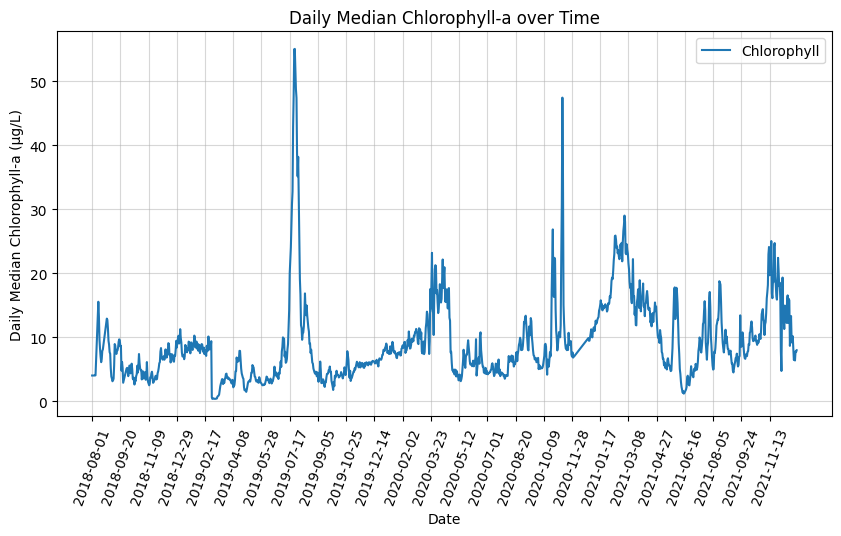

In [86]:
# @title Visualization of Chlorophyll distribution
# @markdown This plot shows the variation of daily median Chlorophyll-a concentration over time. This plot provides insights into the temporal trends and fluctuations in Chlorophyll-a concentration.
plt.figure(figsize=(10, 5))

plt.plot(df['Date'], df['daily_median_chla_interp_ugL'], label="Chlorophyll")
plt.xticks(df['Date'][::50], rotation=70)
plt.grid(visible=True, alpha=0.5)

# Set labels and title
plt.xlabel('Date')
plt.ylabel(u'Daily Median Chlorophyll-a (\u03bcg/L)')
plt.title('Daily Median Chlorophyll-a over Time')

plt.legend()
plt.show()



---


#### Create an utility object
We create an object of the Utils class, it contains all the utility functions like splitting train and test data, normalizing the data, etc.

In [87]:
'''
Utility instance - to perform data processing, train test split
'''
utils = Utils(num_features=len(feature_cols), inp_cols=feature_cols, target_cols=target_cols, date_col=date_col,
              input_window=input_window, output_window=output_window, num_out_features=output_size, stride=stride)

---

#### Train Test split
Ideally, a 3-way split is done - train, val and test.

- The **training** set is used to teach or "train" the machine learning model. It contains the majority of the data and is where the model learns the relationships between the features and the target variable.

- The **test** set is used to assess the performance of the model. The test set acts as new, unseen data for the model, simulating how the model will perform in real-world scenarios

- The **validation** split is generally used to tune the hyper-parameters during training. Once the hyper-parameters are tuned, the model is re-trained on the train+val data. To keep the notebook short and simple, hyper-parameter tuning is not included.

In [88]:
'''
Split data into train and test
'''
df_train, df_test = utils.train_test_split(df, split_ratio=split_ratio)

In [89]:
# @title  { display-mode: "form" }
# @markdown Data shape is as follows.
print("The main data set consists of {} number of data, which is splitted to {} number of train and {} number of test instances.".format(df.shape[0], df_train.shape[0], df_test.shape[0]))


The main data set consists of 1249 number of data, which is splitted to 749 number of train and 500 number of test instances.




---


#### Normalize the data
Standard normalization, also known as Z-score normalization, is a common technique used to scale features to have a mean of 0 and a standard deviation of 1. This process transforms the data distribution to have a mean of 0 and a variance of 1, making it easier to compare and analyze different features.

$$ \text{Normalized value} = \frac{{\text{Original value} - \text{Mean}}}{{\text{Standard deviation}}} $$


In [90]:
df_train = utils.normalize(df_train)
df_test = utils.normalize(df_test, use_stat=True)



---
#### Generating data samples via sliding window

ToDO: describe overall look of sample before going into details.

- **Lookback Window:**

This is the size of the window that determines how many past time steps are considered as input features for predicting the future. In the context of LSTM, the network will learn patterns in the data based on the observations within this lookback window.

- **Horizon Window:**

This represents the size of the window into the future that the model aims to predict. It determines how far ahead the LSTM model will forecast.

- **Sample:**

A single instance or observation used for training the LSTM model. Each sample consists of the input features (observations from the lookback window) and the target output (observations from the horizon window).

- **Sliding Window:**

This refers to the technique of moving a fixed-size window (or interval) across the time series data. At each step, the window slides forward by a certain number of time steps. This approach allows us to create multiple samples or training instances from the time series data.


Putting it all together, "1 sliding window = 1 lookback window + 1 horizon window = 1 sample"



<p align="center">
  <img src="https://github.com/sepidehfat/Eco_KGML_workshop/blob/main/Images/window.png?raw=true" alt="Image Title">
</p>



In [91]:
'''
Prepare data : 1 training sample = lookback window + horizon window
'''
X_train, Y_train = utils.windowed_dataset(df_train)
X_test, Y_test = utils.windowed_dataset(df_test)

In [92]:
# @title  { display-mode: "form" }
# @markdown Data shape is as follows.
print("There are {} number of train samples and {} number of test samples.".format(X_train.shape[0], X_test.shape[0]))
print("Each sample consists of {} number of features, which are the input of the model.".format(X_train.shape[2]))
print("For sampling, the window size is: {}".format(X_train.shape[1]))


There are 729 number of train samples and 480 number of test samples.
Each sample consists of 15 number of features, which are the input of the model.
For sampling, the window size is: 14




---


## 3. Modeling

**Long Short-Term Memory (LSTM)** is a type of recurrent neural network (RNN) architecture designed to capturing long-term dependencies.


LSTM works by selectively updating and forgetting information through the gating mechanisms. The input gate allows relevant information to be added to the memory, while the forget gate filters out unnecessary information. This mechanism enables the LSTM to capture long-term dependencies in sequential data.


**The Seq2Seq (Sequence-to-Sequence)** model with LSTM consists of two main components.

- The **encoder** processes the input sequence and compresses the information into a fixed-length context vector or hidden state.
The final hidden state of the encoder contains a summarized representation of the entire input sequence, which is then passed to the decoder.

- The **decoder** consists of another LSTM network which takes the output of the encoder as an input, and generates the output sequence for forecasting window.


<p align="center">
  <img src="https://github.com/sepidehfat/Eco_KGML_workshop/blob/main/Images/enc_dec.png?raw=true" alt="Image Title">
</p>



---


#### Define the model
<!--
<div align="center">
  <div style="background-color: white;">
    <img src="https://github.com/sepidehfat/Eco_KGML_workshop/blob/main/LSTM.png?raw=true" alt="Image Title">
  </div>
</div> -->

<!-- https://colah.github.io/posts/2015-08-Understanding-LSTMs/ -->



In [93]:
'''
Create the seq2seq model
'''
model = seq2seq(input_size = X_train.shape[2],
                hidden_size = hidden_feature_size,
                output_size=output_size,
                model_type=model_type,
                num_layers = num_layers,
                utils=utils,
                dropout=dropout,
                device=device
               )



---


#### Train the model

If you set `load_pretrained` to true, this allows you to use a previously pretrained model for evaluation purposes.

In [94]:
'''
Train the model
'''
load_pretrained = False

if not load_pretrained:
  loss, test_rmse, train_rmse = model.train_model(X_train,
                                                  Y_train,
                                                  X_test,
                                                  Y_test,
                                                  target_len = output_window,
                                                  config = config,
                                                  training_prediction = training_prediction
                                                  )

100%|██████████| 100/100 [00:22<00:00,  4.52it/s, loss=0.302, test_rmse=4.89, train_rmse=3.4]




---

### Plot train-test RMSE

**Root Mean Squared Error (RMSE)** is a widely used metric for evaluating the performance of the models. It measures the average deviation of predicted values from the actual values in a dataset.

RMSE is calculated by taking the square root of the average of the squared differences between the predicted values and the actual values. Mathematically, it is represented as:

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

Where \( n \) is the number of samples in the dataset, $( y_i )$ is the actual value of the target variable for the $( i^{th} )$ sample, and $( \hat{y}_i)$ is the predicted value of the target variable for the $( i^{th} )$ sample.






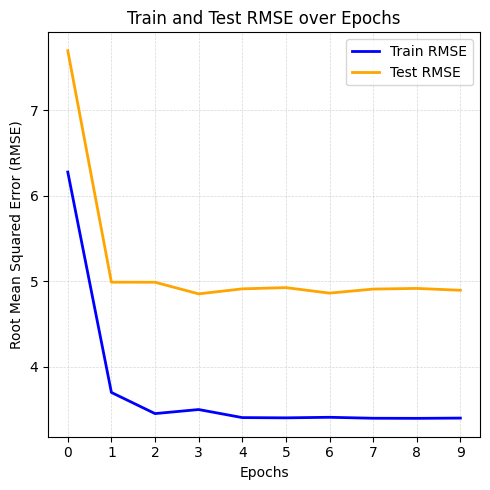

In [95]:
# @title  { display-mode: "form" }
if not load_pretrained:
  utils.plot_RMSE_epochs(test_rmse, train_rmse)



---



### Save the model

You can save the model weights to have it as a refrence. By saving the weights, you preserve the learned parameters, enabling you to reload the model in its trained state. This can be particularly useful for tasks where training the model is time-consuming or resource-intensive.

In [96]:
MODEL_PATH_SAVE = "./model_weights"
torch.save(model.state_dict(), MODEL_PATH_SAVE)



---


### Load the model for evaluation



By setting `load_current` to true, you would use the weights of the model that you have already trained. This option is beneficial when you want to continue training from a specific checkpoint or fine-tune the model on your own dataset


In [97]:
# paths to load the model
MODEL_PATH_PRETRAINED = "./Eco_KGML_workshop/pretrained_model_weights"
MODEL_PATH_CURRENT = "./model_weights"

if load_pretrained:
    model.load_state_dict(torch.load(MODEL_PATH_PRETRAINED))
    print("The model is loaded from github.")
else:
    model.load_state_dict(torch.load(MODEL_PATH_CURRENT))
    print("Loaded the model you currently trained.")

Loaded the model you currently trained.




---


## 4. Evaluation and Plotting

### Evaluation


`evaluate_batch` evaluates the performance of the model on a train and test dataset. It computes predictions and calculates the Root Mean Squared Error (RMSE) between the predicted and true values, and returns a dictionary containing the predictions, true values, and RMSE.

In [98]:
'''
Perform evaluation
'''
train_eval_dict = model.evaluate_batch(X_train.to(device), Y_train.to(device))
test_eval_dict = model.evaluate_batch(X_test.to(device), Y_test.to(device))

### Visualizations of evaluation

Here we can see the plots of the predicted values for multiple time steps (specified by T) alongside the ground-truth values. We can see the model's predictions over time, and comparing them to the actual observed values. The x-axis represents the timeline, and the y-axis represents the predicted chlorophyll values at different time steps.

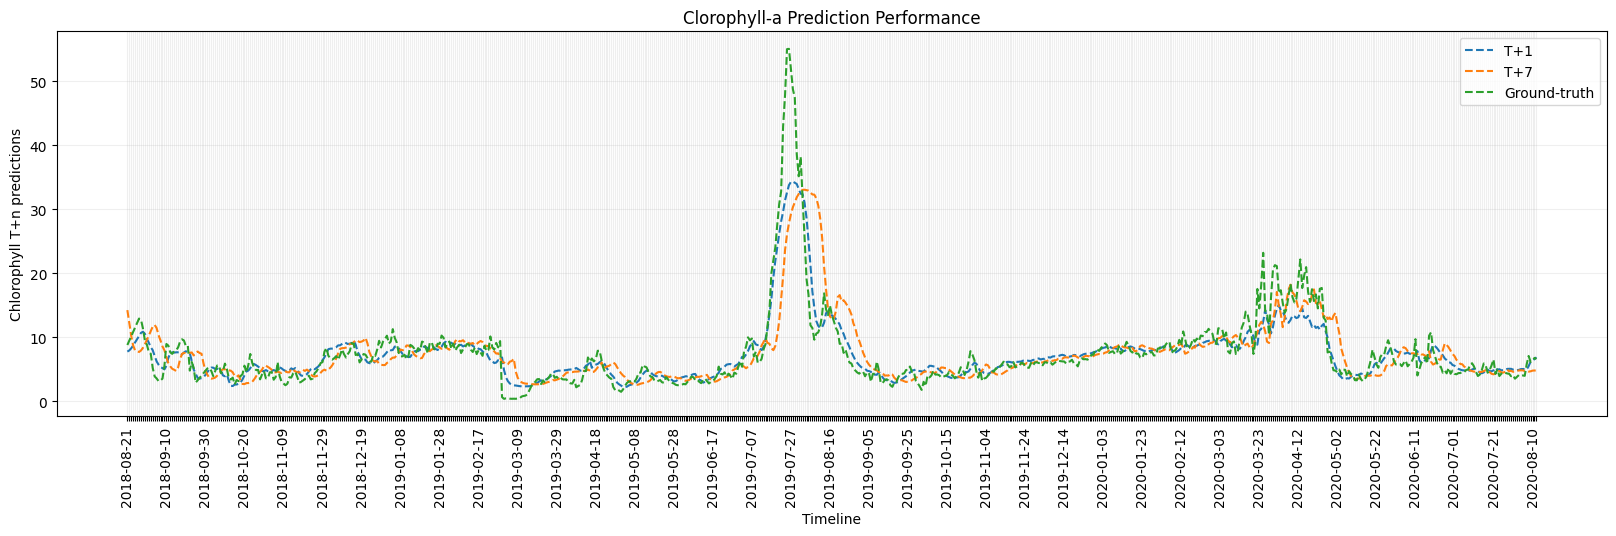

In [99]:
'''
Generate the plots on train data
'''

# Specify the list of T+n predictions to plot
horizon_range = [1, 7] # this will plot T+1 and T+n predictions w.r.t Ground truth

utils.plot_predictions(df_train, train_eval_dict, horizon_range)

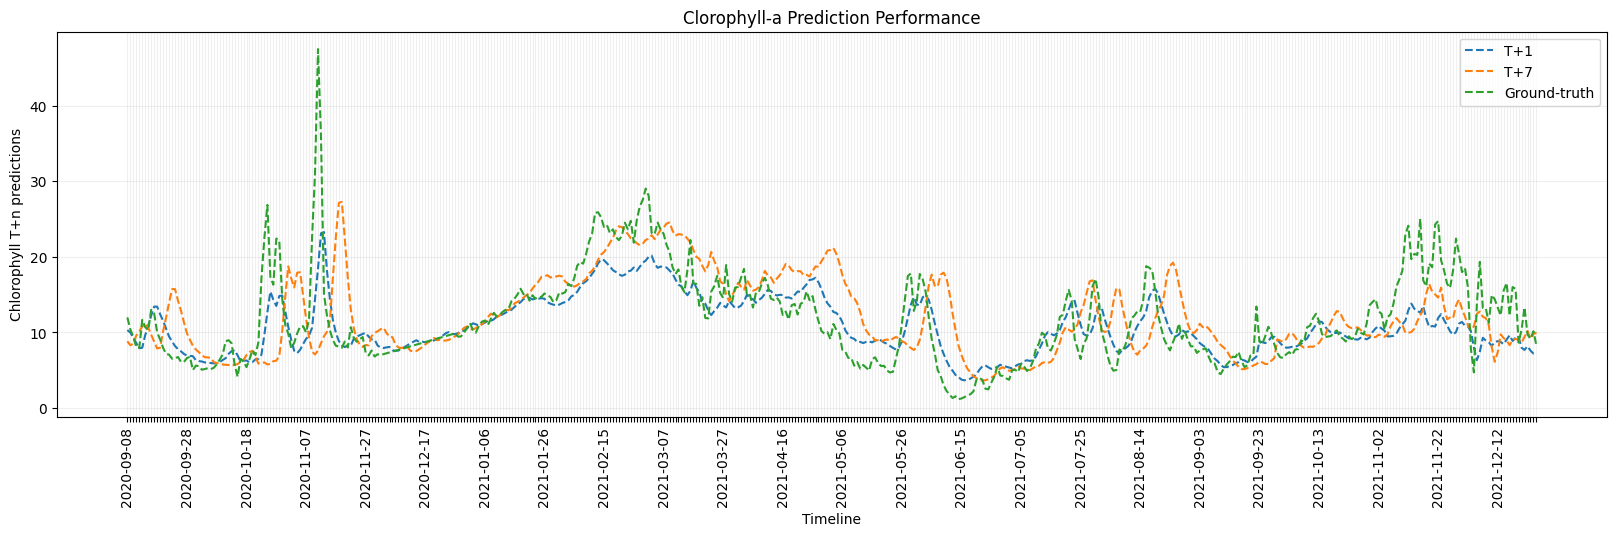

In [100]:
'''
Generate the plots on test data
'''

# Specify the list of T+n predictions to plot
horizon_range = [1,7] # this will plot T+1 and T+n predictions w.r.t Ground truth

utils.plot_predictions(df_test, test_eval_dict, horizon_range)

### Plot RMSE across different horizons

In this part, Root Mean Squared Error (RMSE) for each horizon window (T) is calculated. Then we plot the RMSE values for both the training and testing datasets across different horizon windows.

The x-axis represents the horizon window (T+n), and the y-axis represents the RMSE values.

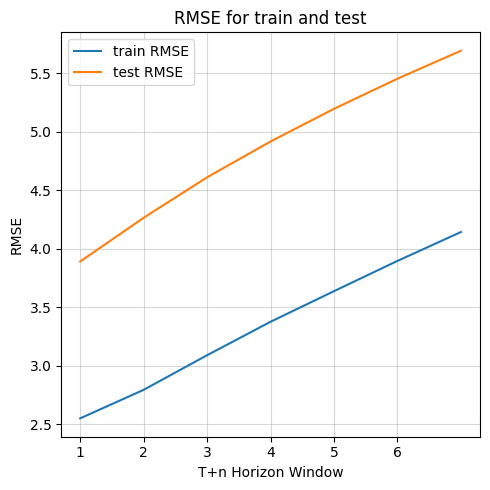

In [101]:
train_rmse_values = utils.calculate_RMSE_horizon(df_train, train_eval_dict)
test_rmse_values = utils.calculate_RMSE_horizon(df_test, test_eval_dict)
utils.plot_RMSE_horizon(train_rmse_values, test_rmse_values, output_window)